In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm_notebook as tqdm

from kflib import *

plt.rcParams["figure.figsize"] = (20, 6)

## ローレンツ96のモデルを作る
6h = 0.05 step

In [2]:
N = 40
F = 8
x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] += 0.01  # Add small perturbation to the first variable
x = l96_step(x0, 10)

In [3]:
x.shape

(1000, 40)

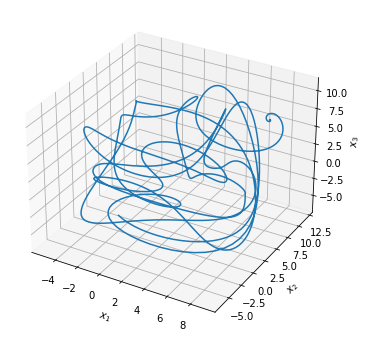

In [4]:

# Plot the first three variables
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(x[:, 0], x[:, 1], x[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()

### 2年分の積分
2 * 365 * 4 * 0.05 = 146.0 step必要

In [5]:
x_one = l96_step(x0, 73.0)  # spin up
x = l96_step(x_one[-1], 73.0)
data = x[::5]
print(data.shape)

(1460, 40)


In [6]:
np.savetxt("gendata.txt", data)

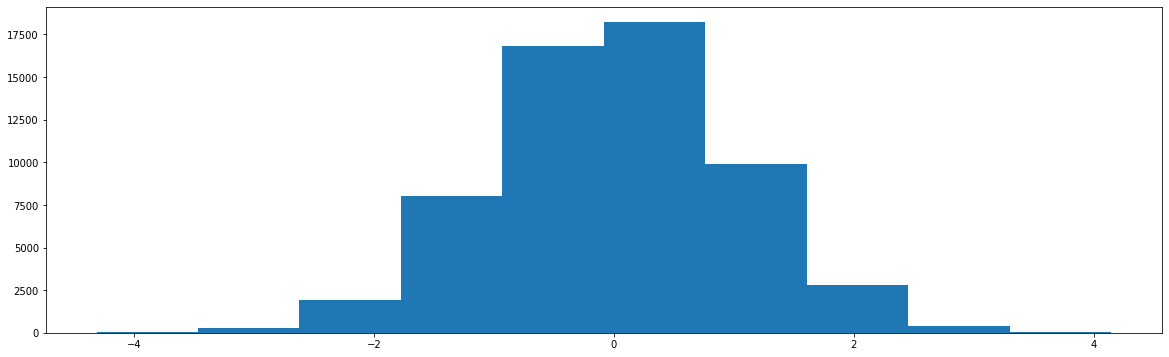

In [7]:
random_ls = np.random.randn(data.shape[0], x[::5].shape[1])
plt.hist(np.ravel(random_ls))
plt.show()

In [8]:
datawithnoise = data + random_ls
np.savetxt("datawithnoise.txt", datawithnoise)
x_last = x_one[-1]

## データ同化システムの構築
カルマンフィルタ

In [9]:
xferror_before_assim, xferror_after_assim, trpa = kf(x_last, data, datawithnoise, step=400)

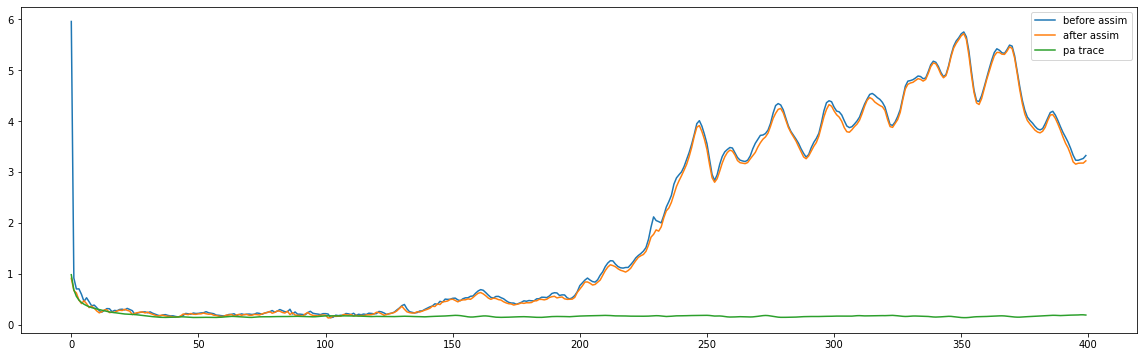

In [10]:
plt.plot(xferror_before_assim, label="before assim")
plt.plot(xferror_after_assim, label="after assim")
# plt.plot(yrmse, label="yt - y")
plt.plot(np.array(trpa), label="pa trace")
plt.legend()
plt.savefig("kf.png")

In [11]:
np.array(xferror_after_assim)[100:].mean()

2.4976366439996256

途中で誤差共分散行列が最初化されたのに、カルマンフィルタが思っている誤差が実際と合わなくなってしまっている

### 誤差共分散膨張

In [12]:
xferror_before_assim, xferror_after_assim, trpa = kf(x_last, data, datawithnoise,step=400, param=1.1)

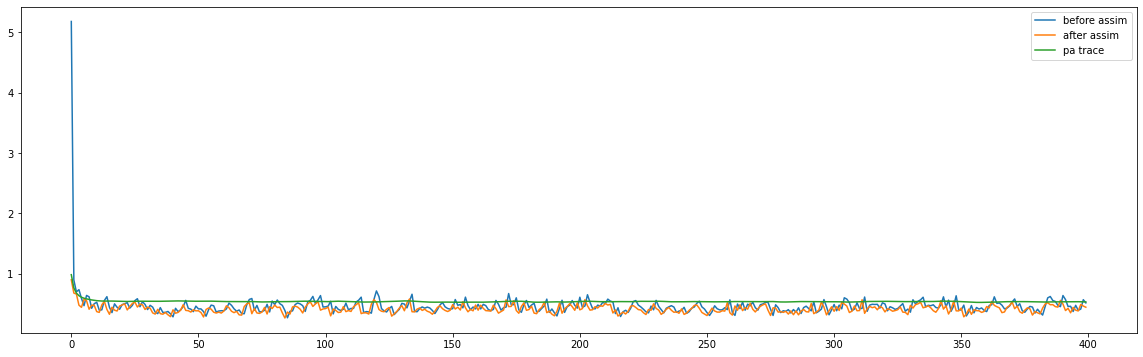

In [13]:
plt.plot(xferror_before_assim, label="before assim")
plt.plot(xferror_after_assim, label="after assim")
plt.plot(np.array(trpa), label="pa trace")
plt.legend()
plt.savefig("kf.png")

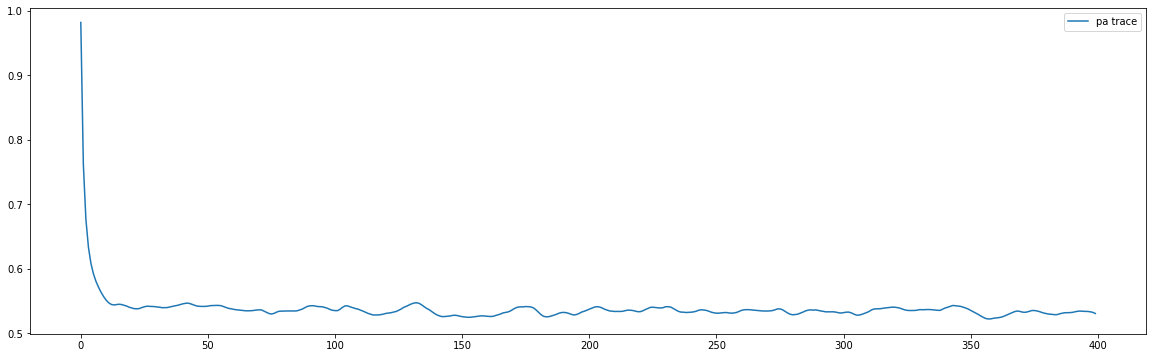

In [14]:
plt.plot(np.array(trpa), label="pa trace")
plt.legend()
plt.show()

### 三次元変分法

In [15]:
xferror_before_assim, xferror_after_assim, trpa = henbun(x_last, data, datawithnoise)

In [16]:
np.array(xferror_after_assim).mean()

0.6060032151003212

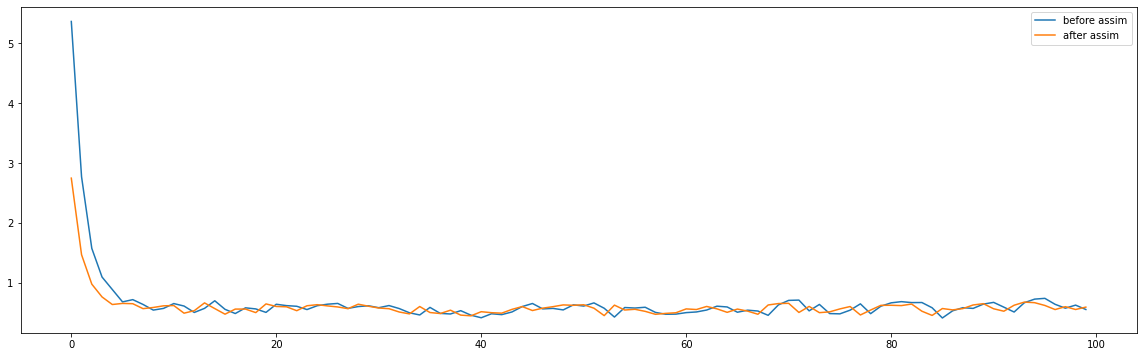

In [17]:
plt.plot(xferror_before_assim, label="before assim")
plt.plot(xferror_after_assim, label="after assim")
plt.legend()
plt.savefig("3henbun.png")

### KFのチューニング


In [18]:
hani = np.arange(1.0, 1.05, 0.005)
kf_before_ls = []
kf_after_ls = []
for item in tqdm(hani):
    step = 500
    kf_out = kf(x_last, data, datawithnoise, param=item, step=step) 
    kf_before_ls.append(np.array(kf_out[0][101:]).mean())
    kf_after_ls.append(np.array(kf_out[1][101:]).mean())

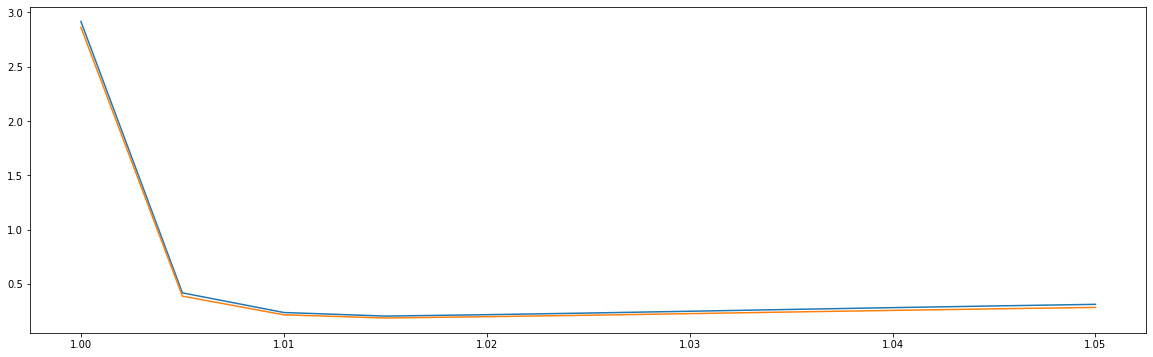

In [19]:
plt.plot(hani, kf_before_ls,label='before_assim')
plt.plot(hani, kf_after_ls,label='after_assim')
plt.savefig('param.png')

In [20]:
print(kf_after_ls)

[2.8634121979378104, 0.3877634504466175, 0.21574476052589933, 0.1865685377195074, 0.19845068660217458, 0.21191418540721943, 0.2265392388542757, 0.24166595794921278, 0.25637490138043295, 0.27040001465786123, 0.2838307277559751]


### NMC法でBを決める

In [ ]:
def NMC():
    B = np.eye(N)

### 観測を減らす
まずはランダムに減らしてみる

In [ ]:
# RMSEを入れる
kf_kansoku = []
henbun_kansoku = []

In [ ]:
for i in range(0, 20):
    print("start to delete ramdom {} row".format(i))
    step = 300
    kf_val = 0.0
    henbun_val = 0.0
    del_key = np.random.choice(N, i, replace=False)
    kf_out = kf(x_last, data, datawithnoise, param=1.1, step=step, del_key=del_key)
    henbun_out = henbun(x_last, data, datawithnoise, step=step, del_key=del_key)
    kf_val += np.array(kf_out[1][101:]).mean()
    henbun_val += np.array(henbun_out[1][101:]).mean()
    kf_kansoku.append(kf_val)
    henbun_kansoku.append(henbun_val)

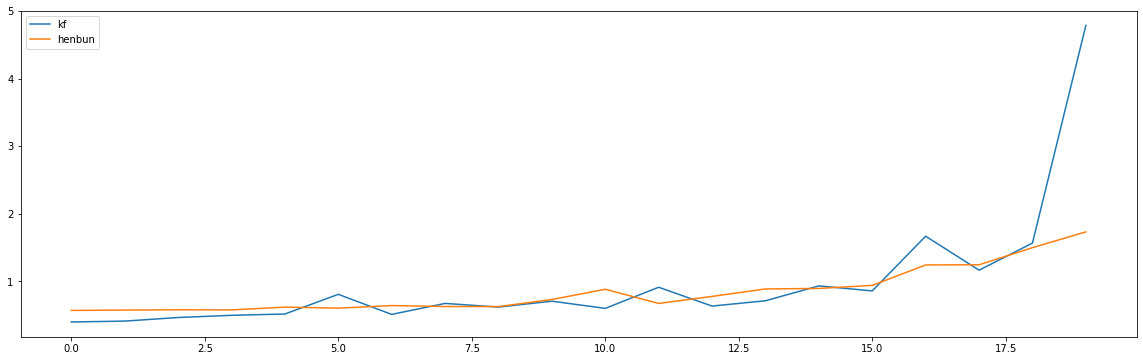

In [68]:
plt.plot(kf_kansoku, label='kf')
plt.plot(henbun_kansoku,label='henbun')
plt.legend()
plt.savefig("Kansokugosa.png")

In [75]:
# RMSEを入れる
kf_kansoku = []
henbun_kansoku = []
for i in range(0, 20):
    print("start to delete ramdom {} row".format(i))
    step = 300
    rec =1 
    kf_val = 0.0
    henbun_val = 0.0
    for _ in range(rec):
        del_key = np.random.choice(N, i, replace=False)
        kf_out = kf(x_last, data, datawithnoise, param=1.1, step=step, del_key=del_key)
        henbun_out = henbun(x_last, data, datawithnoise, step=step, del_key=del_key)
        kf_val += np.array(kf_out[1][101:]).mean()
        henbun_val += np.array(henbun_out[1][101:]).mean()
    kf_kansoku.append(kf_val / rec)
    henbun_kansoku.append(henbun_val /rec)

start to delete ramdom 0 row



start to delete ramdom 1 row



start to delete ramdom 2 row



start to delete ramdom 3 row



start to delete ramdom 4 row



start to delete ramdom 5 row



start to delete ramdom 6 row



start to delete ramdom 7 row



start to delete ramdom 8 row



start to delete ramdom 9 row



start to delete ramdom 10 row



start to delete ramdom 11 row



start to delete ramdom 12 row



start to delete ramdom 13 row



start to delete ramdom 14 row



start to delete ramdom 15 row



start to delete ramdom 16 row



start to delete ramdom 17 row



start to delete ramdom 18 row



start to delete ramdom 19 row


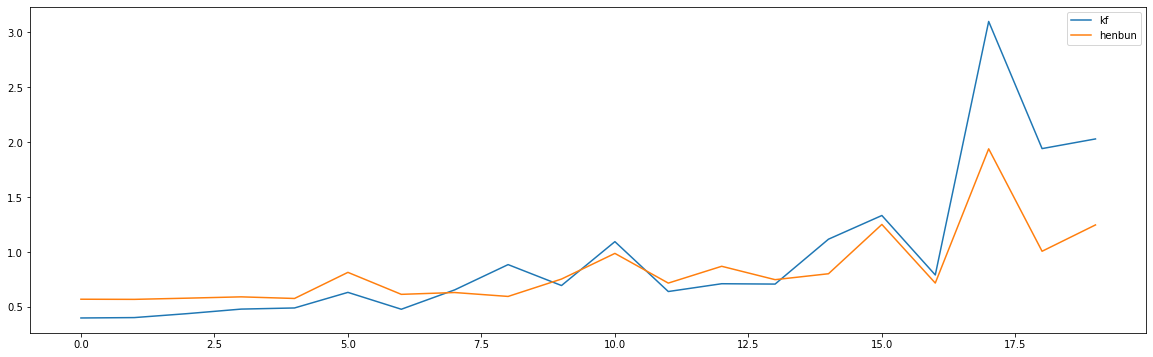

In [76]:
plt.plot(kf_kansoku, label='kf')
plt.plot(henbun_kansoku,label='henbun')
plt.legend()
plt.savefig("Kansokugosa_20.png")